http://nimadehmamy.com/3dviz-colors

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
import pandas as pd

In [3]:
import net3d_3_v11_5 as n3

net3d_v9_4_10:8: ImportWarning: Can't import tensorflow!


In [4]:
node_info = pd.read_excel('./data/hierarchical_metrics_german_3.xlsx')[['node', 'cent','f_hierarchical_levels', 'f_influence_centrality', 'node func']].values
#edge_info = pd.read_csv('./data/german_ling_network_3.xlsx')[['Source', 'Target', 'frequency', 'cent']].values
edge_info = pd.read_excel('./data/german_ling_network_3.xlsx')[['Source', 'Target', 'frequency', 'cent']].values

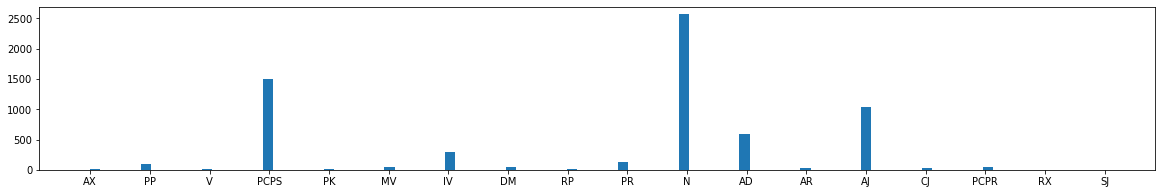

In [5]:
figure(figsize(20, 3))
hist(node_info[:,4], 100);

In [6]:
colors = {'AD': '#20639b', 'AJ': '#3caea3', 'AR': '#808080', 'AX': '#808080', 'CJ': '#808080','DM': '#808080', 'IV': '#173f5f', 'MV': '#808080', 'N': '#ed553b', 'PCPC': '#808080', 'PCPR': '#808080', 'PCPS': '#f6d55c', 'PK': '#808080', 'PP': '#808080', 'PR': '#808080', 'PSPC': '#808080', 'RP': '#808080', 'RX': '#808080', 'SJ': '#808080', 'V': '#808080', 'highlight1': '#a50026', 'highlight2': '#1e8449' }


In [7]:
run_version = 6.0
select_cent = '13'

node_dict = { i[0]: [i[1], i[2], i[3], i[4]] for i in node_info if i[1] == select_cent}

print('Selected cent:', select_cent)

Selected cent: 13


In [8]:
set(node_info[:,1])

{'11', '12', '13', '14E', '14L', '15', '16', '17'}

In [9]:
G = nx.Graph()

for k, v in node_dict.items():
    G.add_node(k , label = k, cent = v[0],  f_hierarchical_levels = v[1], f_influence_centrality = v[2], func = v[3])

for i in edge_info:
    if i[-1] == select_cent:
        G.add_edge( i[0], i[1], weight = int(i[2]))

nx.info(G), nx.is_connected(G)

('Name: \nType: Graph\nNumber of nodes: 697\nNumber of edges: 1325\nAverage degree:   3.8020',
 True)

In [10]:
#nx.write_gexf(G, './11.gexf')

In [11]:
fh = [ v['f_hierarchical_levels'] for k, v in G.nodes(data=True)]
fi = [ v['f_influence_centrality'] for k, v in G.nodes(data=True)]

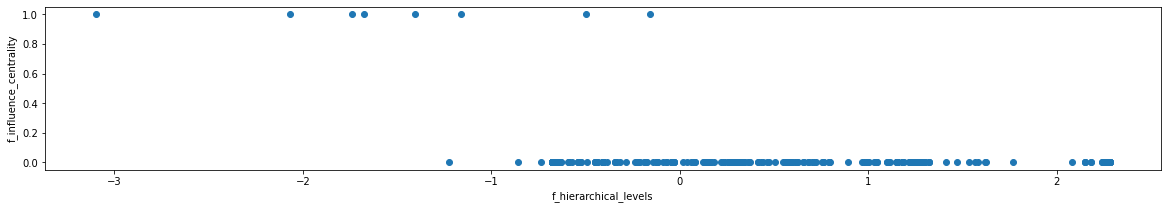

In [12]:
scatter(fh, fi);

xlabel('f_hierarchical_levels')
ylabel('f_influence_centrality');

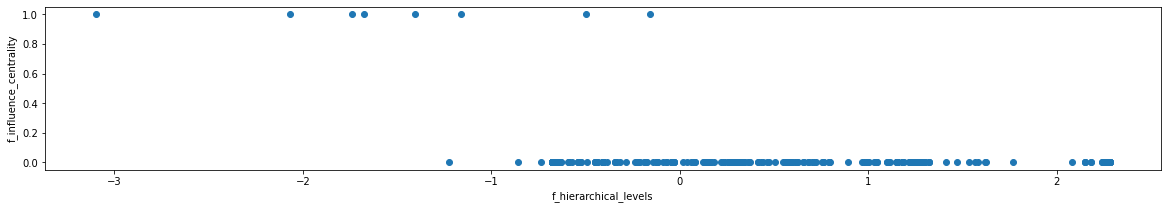

In [13]:
scatter(fh, fi);

xlabel('f_hierarchical_levels')
ylabel('f_influence_centrality');

In [14]:
label = ([ i[0] for i in list(G.nodes(data=True))])

# map nodes labels to integer IDs
mapping = dict([ [label[i], i] for i in range(len(label))])
G_relabel = nx.relabel_nodes(G, mapping)

In [15]:
edge_label = ([ [i[0], i[1], (i[2]['weight'])**(1/4) ]  for i in G_relabel.edges(data=True)])
#edge_label = ([ [i[0], i[1], 1 ]  for i in G_relabel.edges(data=True)])


len(edge_label)

1325

In [16]:
influence = {}

for k, v in G_relabel.nodes(data = True):
    if v['f_influence_centrality'] > 0.1:
        influence[v['label']] = 1
    else:
        influence[v['label']] = 0


In [17]:
groups = { v['label']: v['func']for k, v in G_relabel.nodes(data = True)}


if 'MV können' in list(groups.keys()):
    groups['MV können'] = 'highlight1'
    print('in können')
    
if 'MV mögen' in list(groups.keys()):
    groups['MV mögen'] = 'highlight2'
    print('in mögen')

in können
in mögen


ToDo!
- Transform ranges of hiearchies to a fixed range for all networks!

In [18]:
n = len(label)
pts = 10*rand(n,3)


for i in range(len(label)):
    #if node_dict[label[i]][2] > 0.1:
    #    pts[i][2] = -3*9 #*10 #-2
    #else:
    
    # the vertical position of each nodes is set to its hierarchichal level
    pts[i][2] = node_dict[label[i]][1]*9#*10

pts.shape

(697, 3)

In [19]:
pts_z = pts[:, 2]

In [20]:
class Planar_FDL(n3.netRads):
    def comp_f_short(self):
        A = self.params['A']
        ex = self.params['pow']
        r = self.rad_mat # self.params['n_radius']
        #self.f_short = A * self.dp / r * (self.dpn/r)**(ex-2) * exp(-(self.dpn/r)**ex)
        # we want forces to get stronger for larger nodes because they also have more elastic forces pulling them 
        self.f_short = A * self.dp * r**2 * (self.dpn/r)**(ex-2) * exp(-(self.dpn/r)**ex) #+ r*0.05*self.pts /(sqrt((self.pts**2).sum(-1)[:,newaxis]))*id_virus_mask_circular
        self.f_short[:, 2] = 0
    
    def comp_F_NL(self):
        r = self.rad_mat
        k = self.params['k']
        self.F_NL = - k * self.dp * self.Adj[:,:,newaxis]
        self.F_NL[:, 2] = 0
        
    def comp_f_long(self):
        d = float(self.pts.shape[-1])
        self.f_long = self.params['long_rep'] * self.params['A'] * self.dp / (self.dpn**(d-1) +1e-3)**(d/(d-1))
        self.f_long[:, 2] = 0

        
    def comp_F_NN(self):
        self.comp_f_short()
        self.comp_f_long()
        self.comp_thermal_noise()
    
        self.F_NN = self.f_short + self.f_long 
    
    def iter_(self):
        r = self.params['nodes']['radius']/10.
        self.get_distz()
        self.t += self.dt
        self.tv += [[self.t, self.lens()]]
        self.it_num += 1

        self.compute_forces()
        self.f_max = abs(self.force_mat).max()
        self.update_dt()
       
    
        #h = 10000
        #a = 75
        #b = 100
        radius = 50
        #inside  = lambda x: (( (x[:, 2]**2)/a + (x[:, 1]**2)/b -  (x[:, 0]**2)/h ) < 1)[:,newaxis]+0.01
        inside  = lambda x: ( (x[:, 0])**2 + (x[:, 1])**2 + (x[:, 2])**2 < radius**2)[:,newaxis] +0.001
        
        F = self.force_mat.sum(0)
        
        #F[:,0] = 0
        #F[id_virus,0] = 0
        #F[id_virus,1] = 0
        #F[id_virus_planar, 2]= 0
        F[:, 2]= 0
        
        #ins_sing = inside(self.pts)
        #ins_sing[single_deg] = 1
        
        #self.pts += r * arcsinh( self.dt * (self.force_mat.sum(0))/r)
        #self.pts += r * arcsinh( self.dt * (self.force_mat.sum(0))/r)*inside(self.pts)
        self.pts += r * arcsinh( self.dt * (F)/r)*inside(self.pts)
        self.pts[:,2] = pts_z

In [21]:
# Layour parameters
params_netRads = {
    'A':100,
    'k':10,
    'links':{
        'T0': 0.1,
        'ce': 100.,
        'weighted':True,
        'thickness':1,
    },
   'nodes' : {
        'radius':.1,
        'weighted':True,
        'labels':label,
        'colors': colors, 
        'groups': groups,
        'influence': influence,
       
   },
   
}

In [22]:
#nn = n3.netRads(pts = node_positions, edg= edgelist, **params_netRads)
nn = Planar_FDL(pts = pts, edg= edge_label, **params_netRads)

nn.net_name = f'./result/{select_cent}-{run_version}-'+ nn.net_name 

dt(s) = 17.1


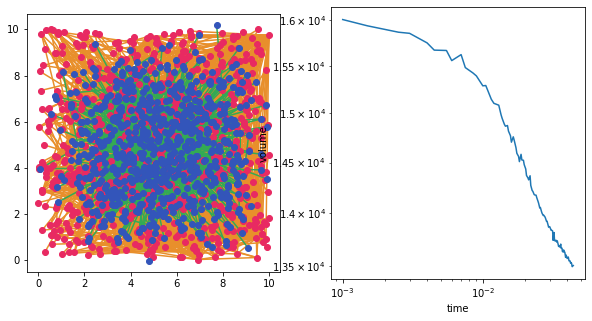

Beginning convergence check ...
dt(s) = 13.7


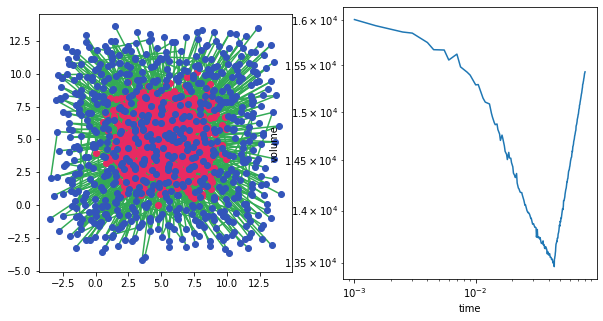


200) ct=0.53,  Has Not Converged! dlog<l>/dlog(t)~0.242 
Checks: (False, False, True)
dt(s) = 16.3


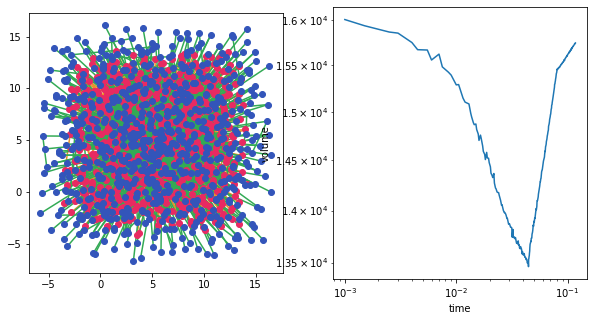


300) ct=0.48,  Has Not Converged! dlog<l>/dlog(t)~0.0486 
Checks: (False, False, True)
dt(s) = 15.7


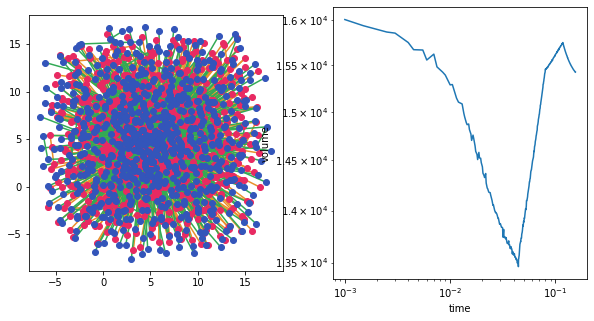


400) ct=0.47,  Has Not Converged! dlog<l>/dlog(t)~-0.0732 
Checks: (True, True, False)
dt(s) = 15.8


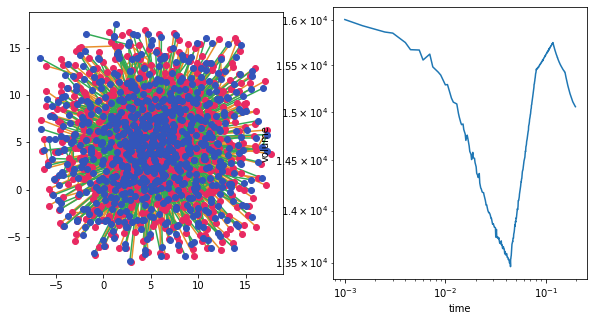


500) ct=0.46,  Has Not Converged! dlog<l>/dlog(t)~-0.103 
Checks: (True, True, False)
dt(s) = 18.6


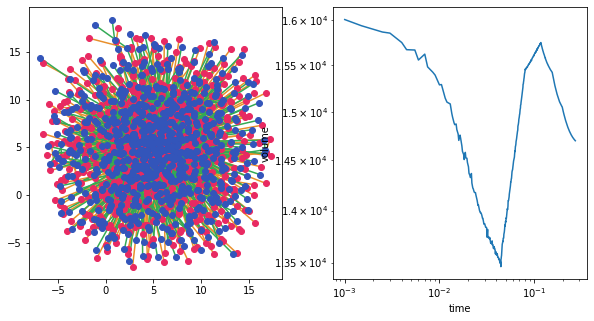


600) ct=0.45,  Has Not Converged! dlog<l>/dlog(t)~-0.0716 
Checks: (True, True, False)
dt(s) = 17.4


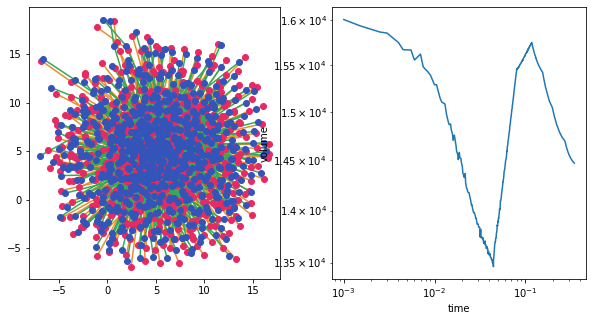


700) ct=0.45,  Has Not Converged! dlog<l>/dlog(t)~-0.0631 
Checks: (True, True, False)
dt(s) = 17.5


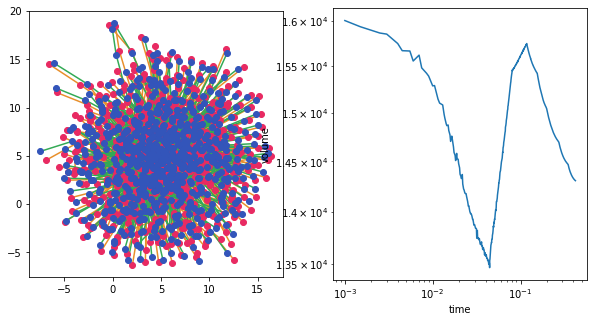


800) ct=0.45,  Has Not Converged! dlog<l>/dlog(t)~-0.0582 
Checks: (True, True, False)
dt(s) = 16.8


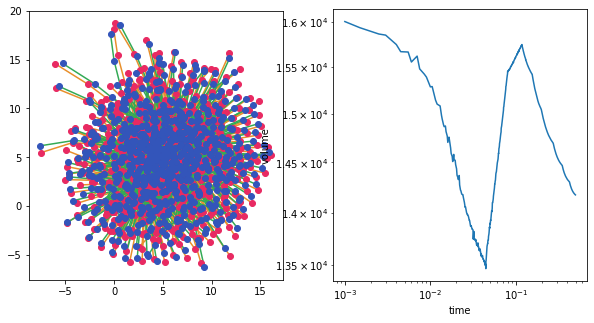


900) ct=0.45,  Has Not Converged! dlog<l>/dlog(t)~-0.0559 
Checks: (True, True, False)
dt(s) = 15.5


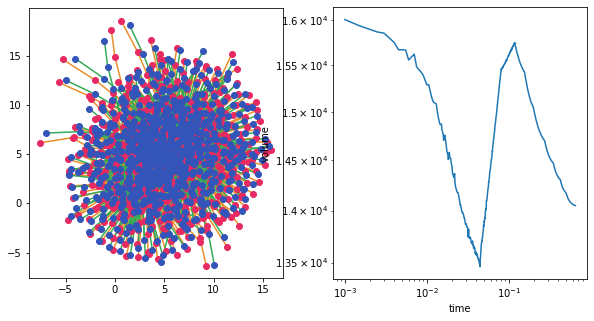


1000) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0333 
Checks: (True, True, False)
dt(s) = 16.7


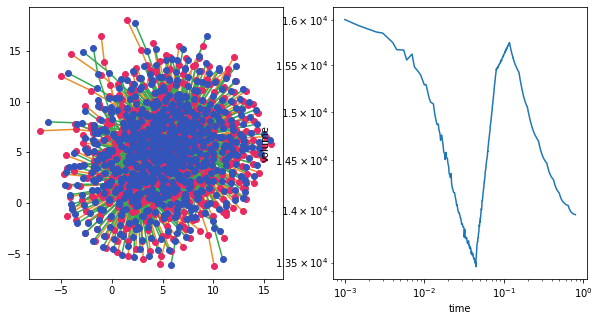


1100) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0292 
Checks: (True, True, False)
dt(s) = 14.6


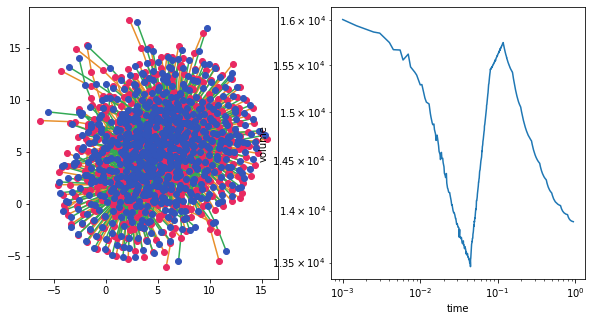


1200) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0277 
Checks: (True, True, False)
dt(s) = 14.3


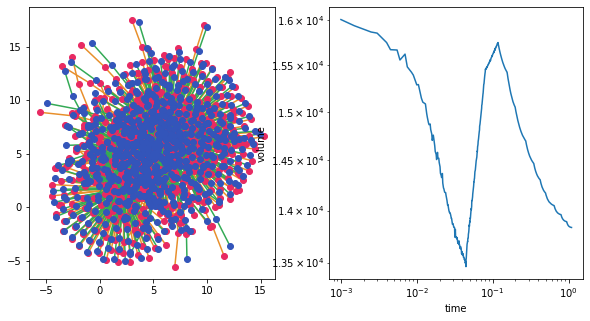


1300) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0269 
Checks: (True, True, False)
dt(s) = 15.1


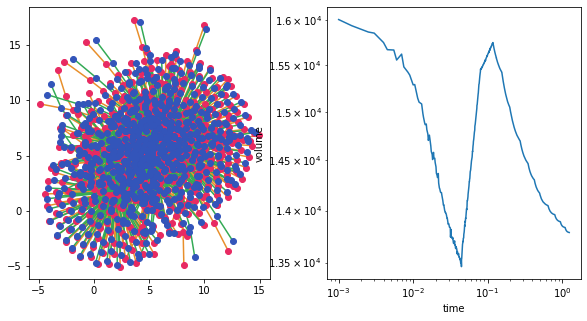


1400) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0269 
Checks: (True, True, False)
dt(s) = 15.5


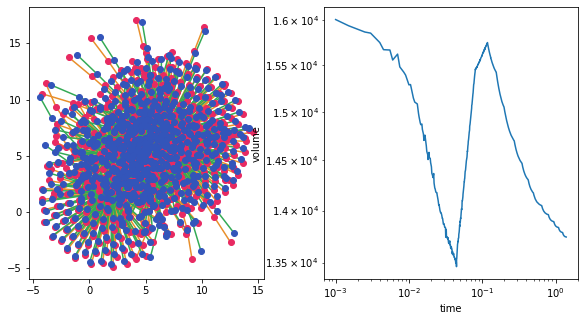


1500) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0273 
Checks: (True, True, False)
dt(s) = 15.2


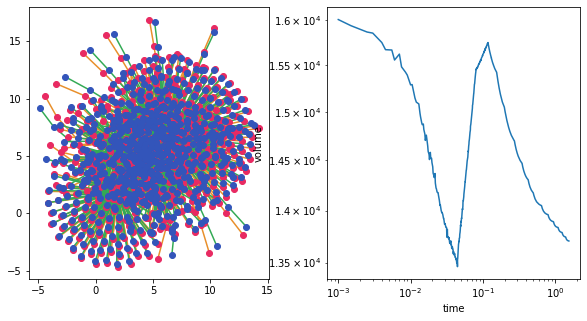


1600) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0271 
Checks: (True, True, False)
dt(s) = 15.1


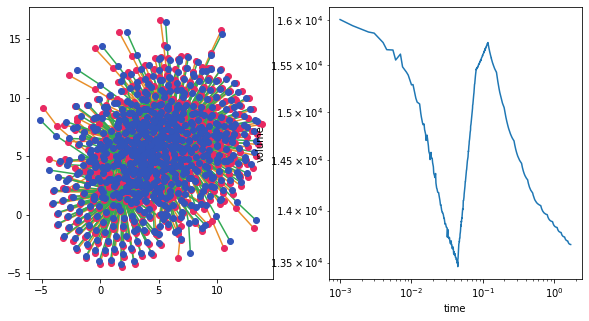


1700) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0262 
Checks: (True, True, False)
dt(s) = 15


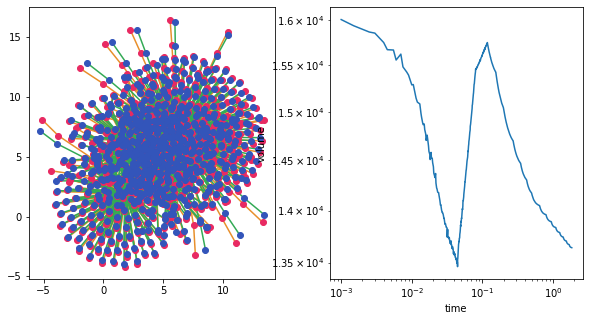


1800) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.026 
Checks: (True, True, False)
dt(s) = 14.8


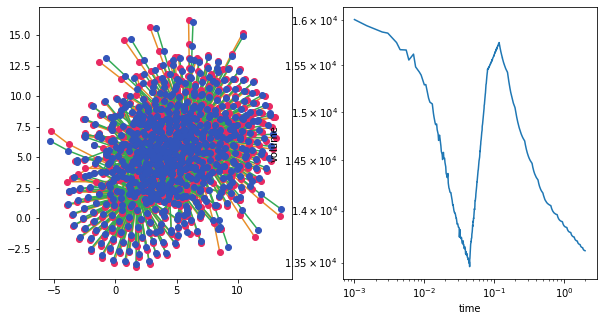


1900) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0269 
Checks: (True, True, False)
dt(s) = 14.9


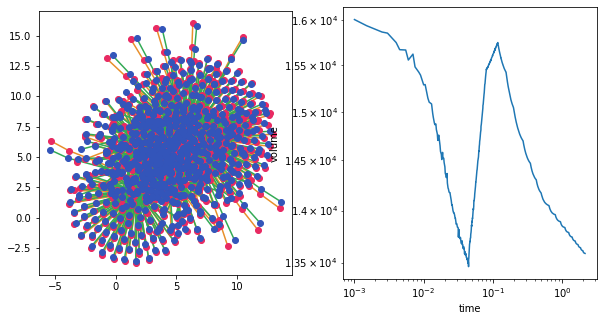


2000) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0262 
Checks: (True, True, False)
dt(s) = 15.3


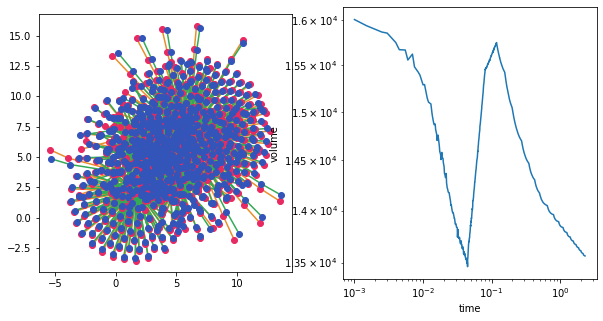


2100) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0258 
Checks: (True, True, False)
dt(s) = 16


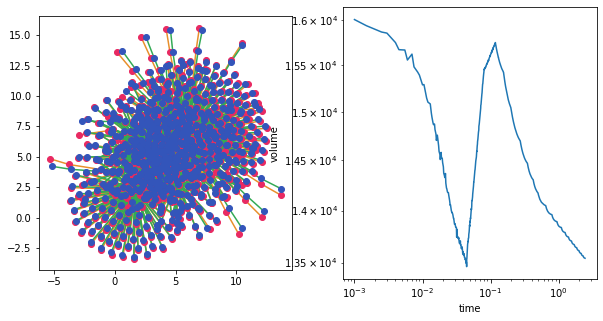


2200) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0253 
Checks: (True, True, False)
dt(s) = 16.8


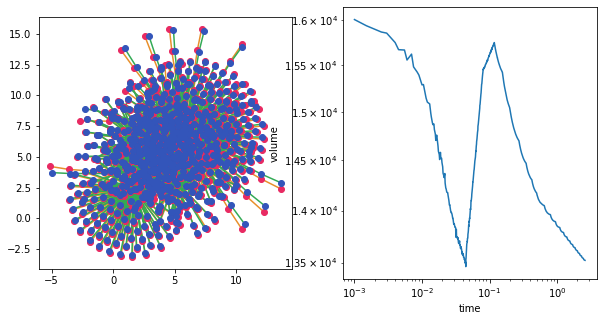


2300) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0245 
Checks: (True, True, False)
dt(s) = 15


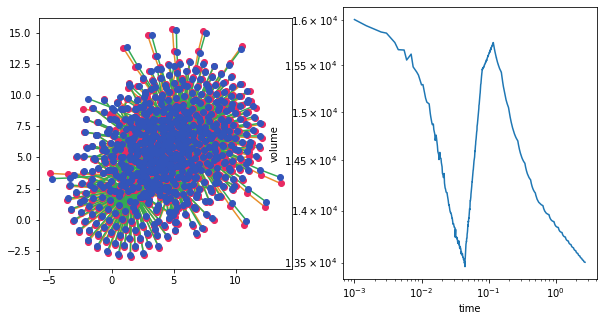


2400) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0241 
Checks: (True, True, False)
dt(s) = 15.2


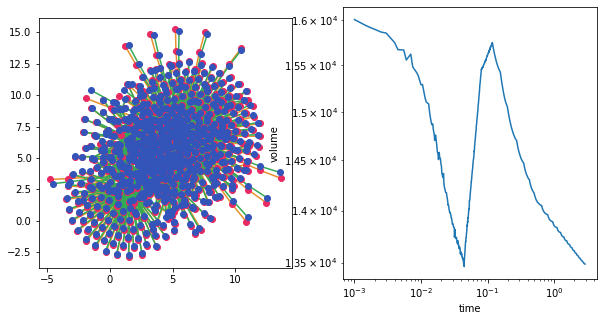


2500) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0235 
Checks: (True, True, False)
dt(s) = 14.2


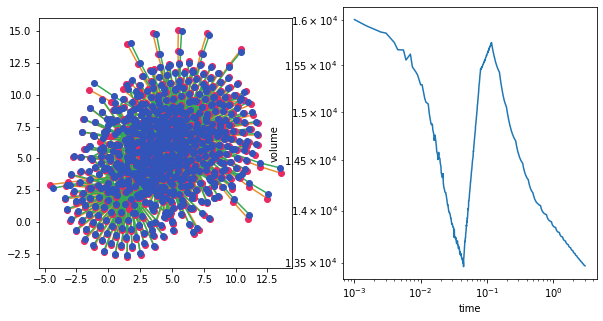


2600) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.023 
Checks: (True, True, False)
dt(s) = 21


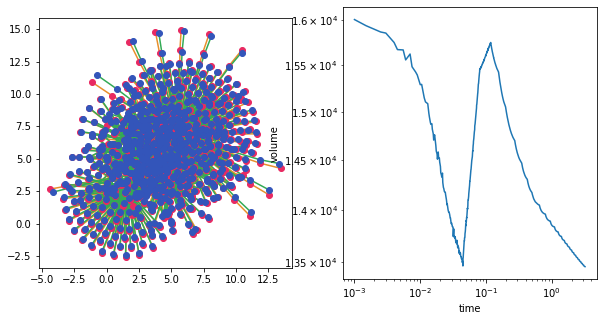


2700) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0224 
Checks: (True, True, False)
dt(s) = 16.4


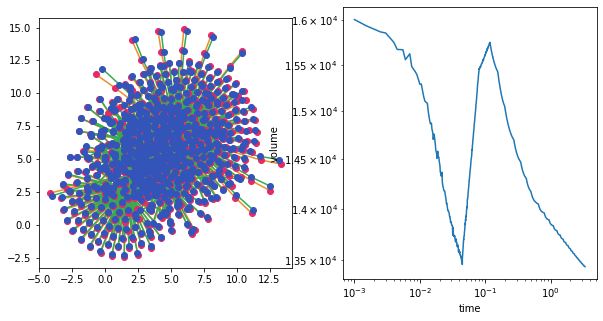


2800) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0221 
Checks: (True, True, False)
dt(s) = 15.7


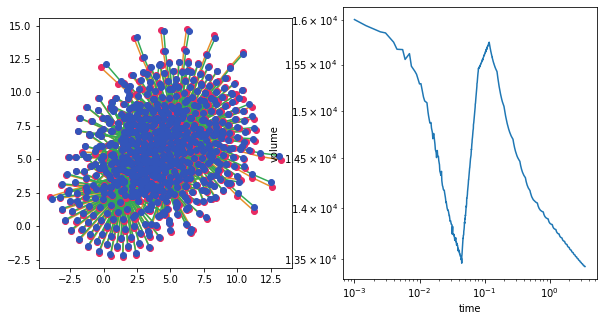


2900) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0213 
Checks: (True, True, False)
dt(s) = 20.6


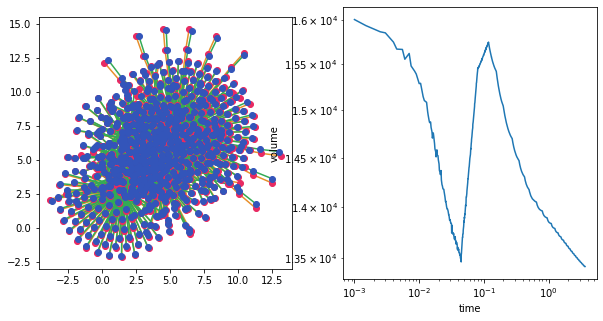


3000) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0214 
Checks: (True, True, False)
dt(s) = 15.1


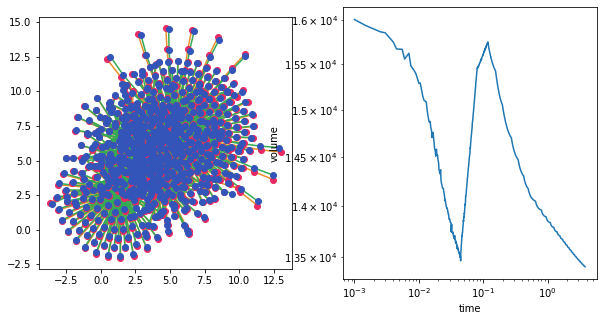


3100) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0208 
Checks: (True, True, False)
dt(s) = 20.4


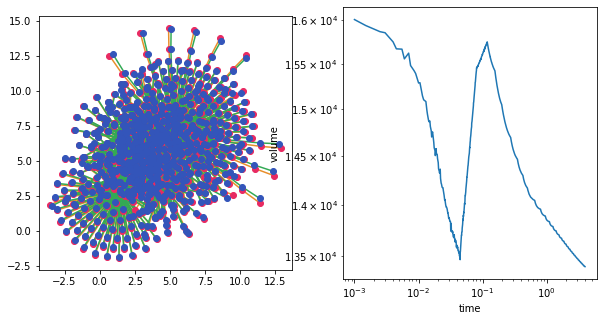


3200) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0201 
Checks: (True, True, False)
dt(s) = 19.5


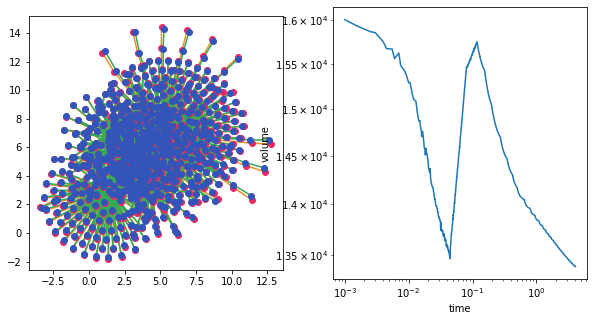


3300) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0197 
Checks: (True, True, False)
dt(s) = 19.8


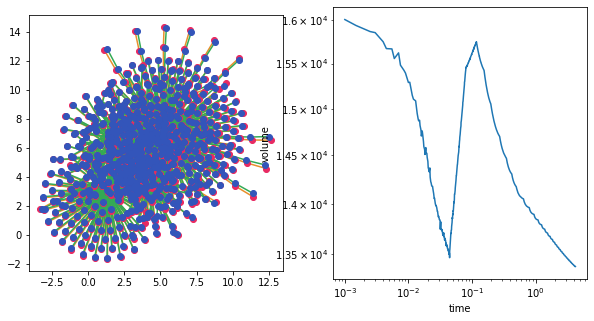


3400) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0195 
Checks: (True, True, False)
dt(s) = 14.9


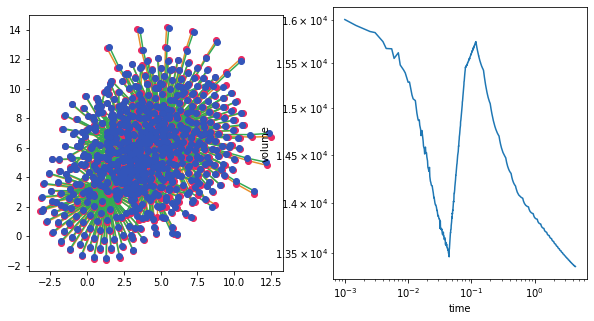


3500) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0187 
Checks: (True, True, False)
dt(s) = 17.3


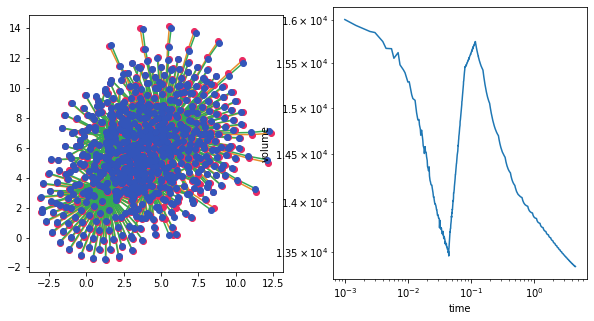


3600) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0186 
Checks: (True, True, False)
dt(s) = 21.1


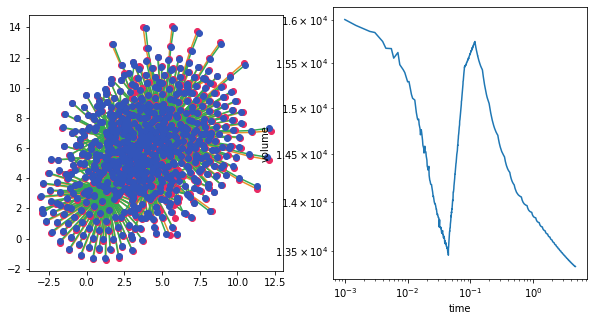


3700) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0181 
Checks: (True, True, False)
dt(s) = 20.8


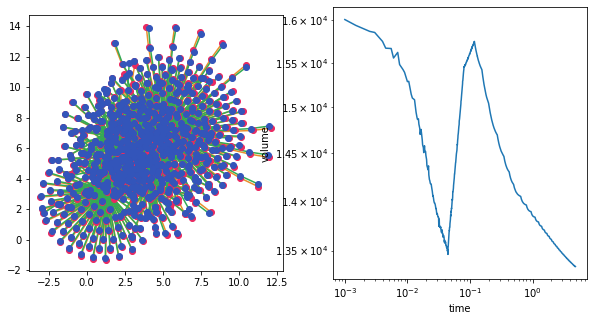


3800) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0181 
Checks: (True, True, False)
dt(s) = 19.9


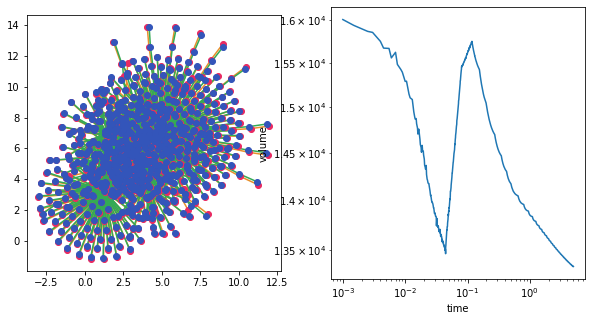


3900) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0171 
Checks: (True, True, False)
dt(s) = 17.9


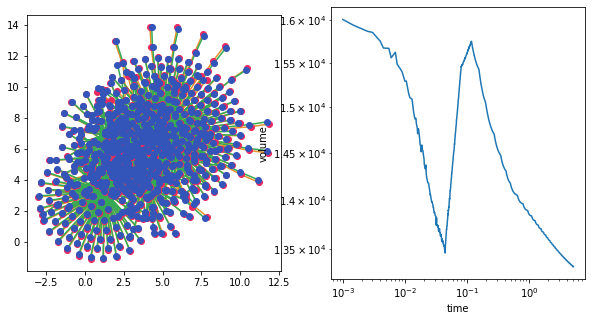


4000) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0169 
Checks: (True, True, False)
dt(s) = 16


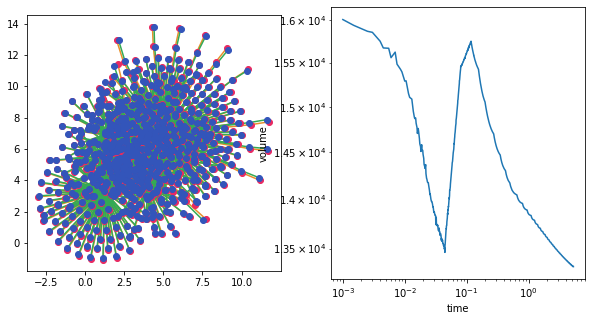


4100) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0164 
Checks: (True, True, False)
dt(s) = 14.4


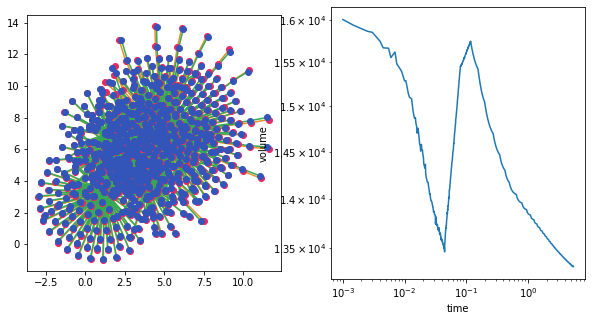


4200) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0157 
Checks: (True, True, False)
dt(s) = 14.6


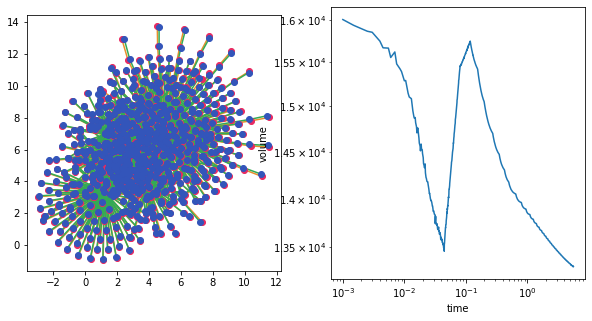


4300) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0155 
Checks: (True, True, False)
dt(s) = 16.4


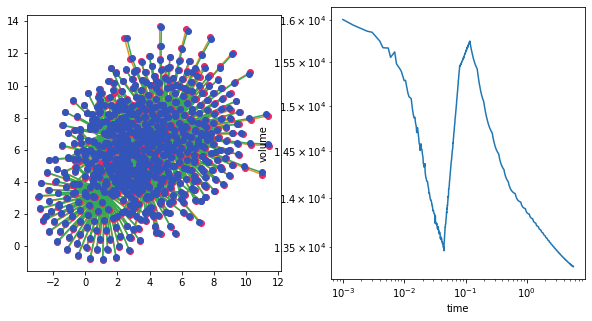


4400) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0148 
Checks: (True, True, False)
dt(s) = 15.9


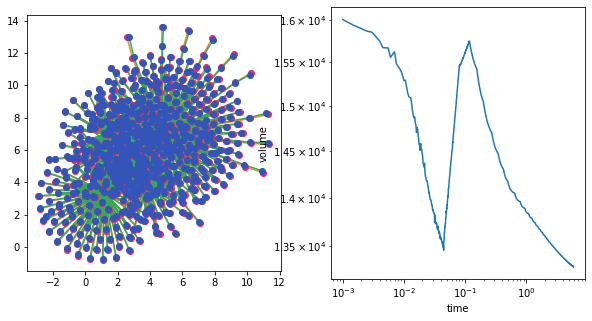


4500) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0148 
Checks: (True, True, False)
dt(s) = 15


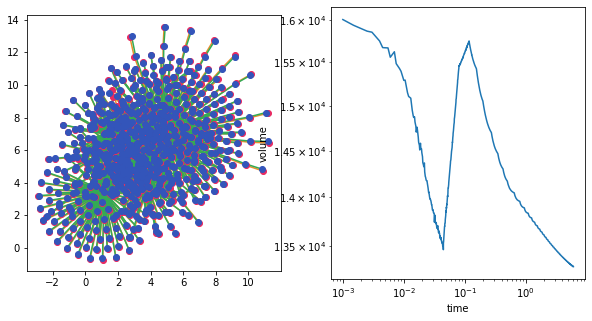


4600) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0148 
Checks: (True, True, False)
dt(s) = 15


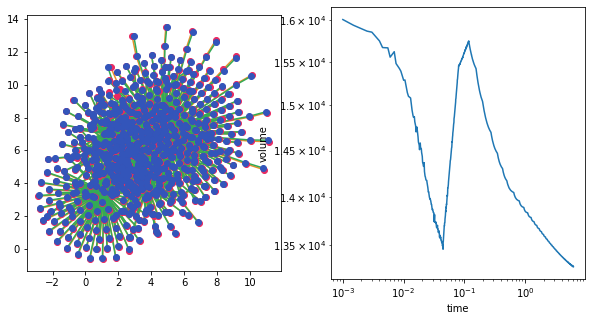


4700) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.0143 
Checks: (True, True, False)
dt(s) = 15


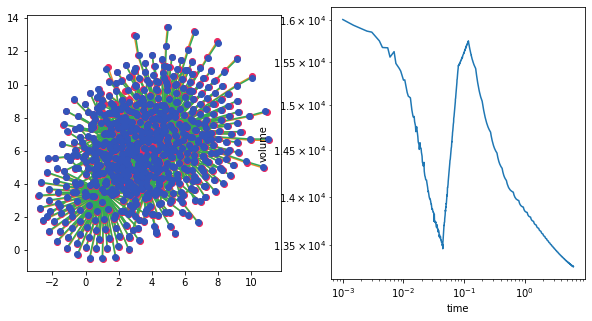


4800) ct=0.44,  Has Not Converged! dlog<l>/dlog(t)~-0.014 
Checks: (True, True, False)
dt(s) = 14.8


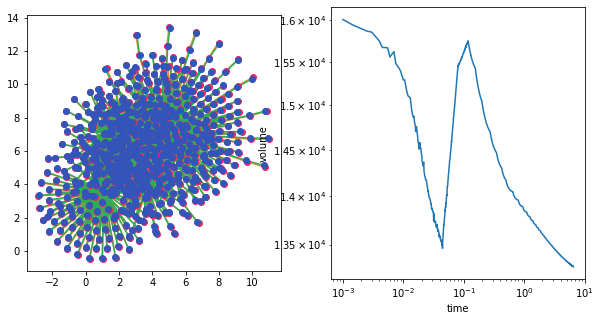


4900) ct=0.43,  Has Not Converged! dlog<l>/dlog(t)~-0.0141 
Checks: (True, True, False)
dt(s) = 15.2


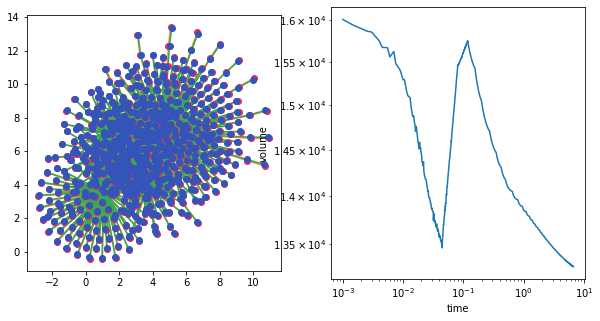


5000) ct=0.43,  Has Not Converged! dlog<l>/dlog(t)~-0.0138 
Checks: (True, True, False)


In [23]:
n3.iter_converge(nn, its = 100, max_its=5000, save_path='./')

In [24]:
#create a big json


In [25]:
#jlo = lambda j: n3.json.load(open(j,'r'))
#net = jlo('./HIV/FDL/test-rs1-net-n214-L320.json')